2022-02-15 12:48:34,689 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s


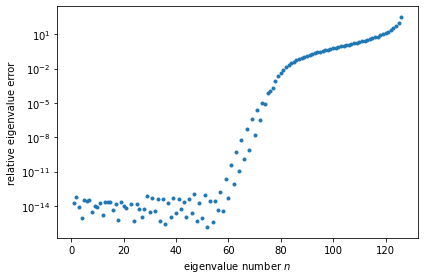

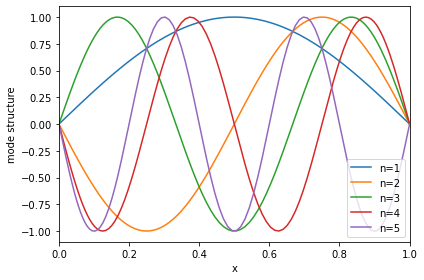

In [4]:
"""
Dedalus script computing the eigenmodes of waves on a clamped string.
This script demonstrates solving a 1D eigenvalue problem and produces
a plot of the relative error of the eigenvalues.  It should take just
a few seconds to run (serial only).

We use a Chebyshev basis to solve the EVP:
    s*u + dx(dx(u)) = 0
    u(x=0) = 0
    u(x=Lx) = 0
where s is the eigenvalue.

For the second derivative on a closed interval, we need two tau terms.
Here we choose to use a first-order formulation, putting one tau term
on an auxiliary first-order variable and another in the PDE, and lifting
both to the first derivative basis.
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Lx = 1
Nx = 128
dtype = np.complex128

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Chebyshev(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(xbasis)

# Fields
u = dist.Field(name='u', bases=xbasis)
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
s = dist.Field(name='s')

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
lift_basis = xbasis.clone_with(a=1/2, b=1/2) # First derivative basis
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction

# Problem
problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
problem.add_equation("s*u + dx(ux) + lift(tau_2) = 0")
problem.add_equation("u(x=0) = 0")
problem.add_equation("u(x=Lx) = 0")

# Solve
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)
n = 1 + np.arange(evals.size)
true_evals = (n * np.pi / Lx)**2
relative_error = np.abs(evals - true_evals) / true_evals

# Plot
plt.figure(figsize=(6, 4))
plt.semilogy(n, relative_error, '.')
plt.xlabel(r"eigenvalue number $n$")
plt.ylabel("relative eigenvalue error")
plt.tight_layout()

plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    plt.plot(x, (u['g']/np.max(u['g'])).real, label=f"n={n}")
plt.xlim(0, 1)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.tight_layout()
plt.savefig("eigenvectors.pdf")

In [8]:
solver.eigenvalues.shape

(130,)